<a href="https://colab.research.google.com/github/makhmudov-khondamir/Machine-Learning-Projects/blob/main/Airline%20Passengers%20Satisfaction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project: Airline passenger satisfaction**
Here's what passengers think about flying in the United States. We use this data to predict passenger satisfaction

In [85]:
import zipfile
import os

# path to the zip file
zip_path = 'aviakompaniya.zip'

# directory for extraction
new_file_name = '/content/extracted_files'

# create the directory if it does not exist
os.makedirs(new_file_name, exist_ok=True)

# and extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(new_file_name)


In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, RocCurveDisplay

In [88]:
df=pd.read_csv('/content/extracted_files/train_dataset.csv')

In [89]:
df.isnull().sum()

,0
id,0
Gender,0
Customer Type,0
Age,0
Type of Travel,0
Class,0
Flight Distance,0
Inflight wifi service,0
Departure/Arrival time convenient,0
Ease of Online booking,0


In [90]:
df.dropna(inplace=True)

In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9972 entries, 0 to 9999
Data columns (total 24 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   id                                 9972 non-null   int64  
 1   Gender                             9972 non-null   object 
 2   Customer Type                      9972 non-null   object 
 3   Age                                9972 non-null   int64  
 4   Type of Travel                     9972 non-null   object 
 5   Class                              9972 non-null   object 
 6   Flight Distance                    9972 non-null   int64  
 7   Inflight wifi service              9972 non-null   int64  
 8   Departure/Arrival time convenient  9972 non-null   int64  
 9   Ease of Online booking             9972 non-null   int64  
 10  Gate location                      9972 non-null   int64  
 11  Food and drink                     9972 non-null   int64  
 1

In [92]:
df.satisfaction.value_counts()

,count
satisfaction,
0,4986
1,4986


In [93]:
a,b=df['satisfaction'].value_counts()/len(df)
print(f'{np.round(a,2)}% of passengers are not satisfied, while the remaining {np.round(b,2)}% are satisfied')

0.5% of passengers are not satisfied, while the remaining 0.5% are satisfied


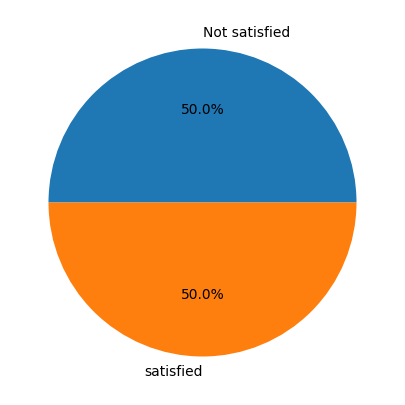

In [94]:
plt.figure(figsize=(10,5))
plt.pie(df['satisfaction'].value_counts(), labels=['Not satisfied','satisfied'], autopct='%1.1f%%')
plt.show()

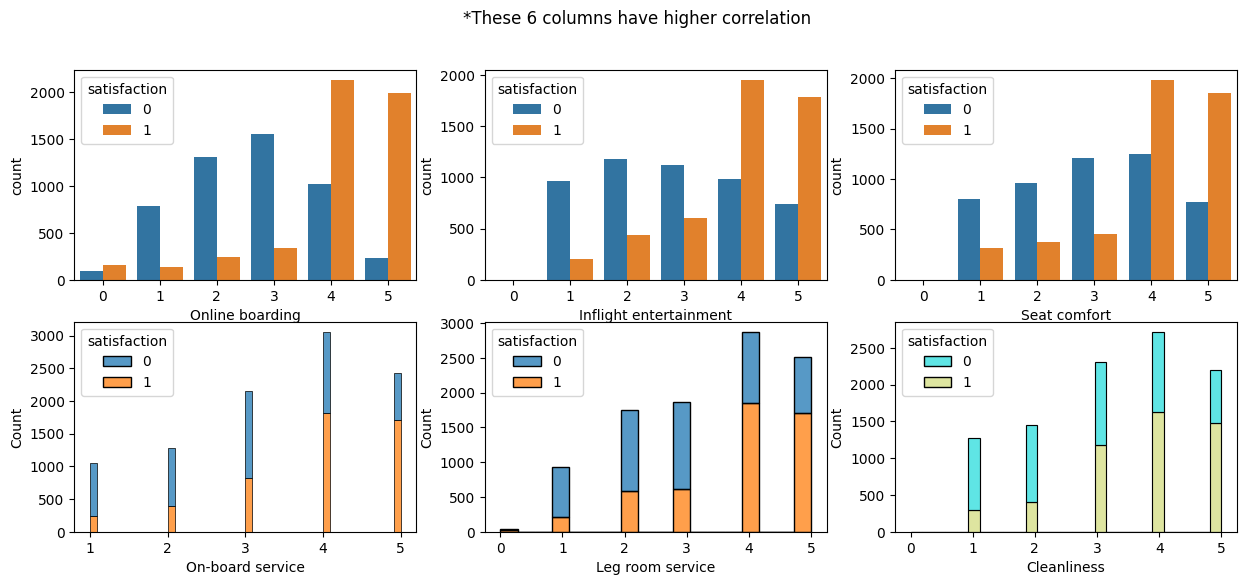

In [95]:
figure, axes=plt.subplots(2,3, figsize=(15,6))
figure.suptitle("*These 6 columns have higher correlation")
sns.countplot(data=df, x=df['Online boarding'], hue='satisfaction', ax=axes[0,0])
sns.countplot(data=df, x=df['Inflight entertainment'], hue='satisfaction', ax=axes[0,1])
sns.countplot(data=df, x=df['Seat comfort'], hue='satisfaction', ax=axes[0,2])
sns.histplot(data=df, x=df['On-board service'], hue='satisfaction', ax=axes[1,0], multiple='stack')
sns.histplot(data=df, x=df['Leg room service'], hue='satisfaction', ax=axes[1,1],multiple='stack')
sns.histplot(data=df, x=df['Cleanliness'], hue='satisfaction', ax=axes[1,2],multiple='stack', palette='rainbow')
plt.show()

In [96]:
df.drop('id',axis=1,inplace=True)

In [97]:
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
numerical_cols = [col for col in numerical_cols if col not in ['id','satisfaction']]


In [98]:
df[numerical_cols].corrwith(df['satisfaction']).sort_values(ascending=False)

,0
Online boarding,0.504671
Inflight entertainment,0.401109
Seat comfort,0.342061
On-board service,0.327361
Leg room service,0.325405
Cleanliness,0.310046
Flight Distance,0.298484
Inflight wifi service,0.277497
Baggage handling,0.248839
Inflight service,0.240580


In [52]:
x=df.drop('satisfaction',axis=1)
y=df['satisfaction']

In [53]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [99]:
catpipeline=Pipeline([
    ('onehot',OneHotEncoder(handle_unknown='ignore'))])
numpipeline=Pipeline([
    ('scaler',StandardScaler())])

fullpipeline=ColumnTransformer([
    ('cat',catpipeline,categorical_cols),
    ('num',numpipeline,numerical_cols)])

In [100]:
Xtrain=fullpipeline.fit_transform(x_train)
Xtest=fullpipeline.transform(x_test)

**Model Training**

In [101]:
rf_model = RandomForestClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42)

In [102]:
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30]
}

xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

In [103]:
rf_grid_search = GridSearchCV(rf_model, rf_param_grid, cv=5, scoring='roc_auc')
rf_grid_search.fit(Xtrain, y_train)
best_rf_model = rf_grid_search.best_estimator_

In [104]:
xgb_grid_search = GridSearchCV(xgb_model, xgb_param_grid, cv=5, scoring='roc_auc')
xgb_grid_search.fit(Xtrain, y_train)
best_xgb_model = xgb_grid_search.best_estimator_

RandomForest Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95      1013
           1       0.96      0.94      0.95       982

    accuracy                           0.95      1995
   macro avg       0.95      0.95      0.95      1995
weighted avg       0.95      0.95      0.95      1995



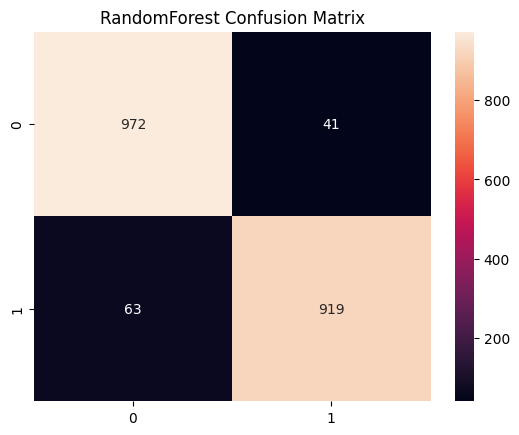

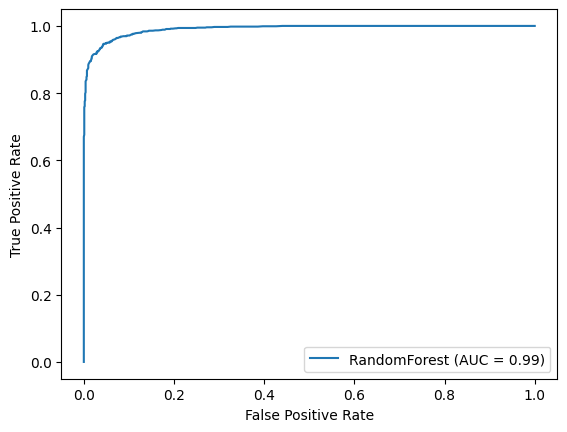

In [105]:
rf_predictions = best_rf_model.predict(Xtest)
rf_conf_matrix = confusion_matrix(y_test, rf_predictions)
print("RandomForest Classification Report:\n", classification_report(y_test, rf_predictions))

sns.heatmap(rf_conf_matrix, annot=True, fmt="g")
plt.title('RandomForest Confusion Matrix')
plt.show()

fpr, tpr, _ = roc_curve(y_test, best_rf_model.predict_proba(Xtest)[:,1])
roc_auc = auc(fpr, tpr)
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='RandomForest').plot()
plt.show()

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96      1013
           1       0.97      0.94      0.95       982

    accuracy                           0.96      1995
   macro avg       0.96      0.96      0.96      1995
weighted avg       0.96      0.96      0.96      1995



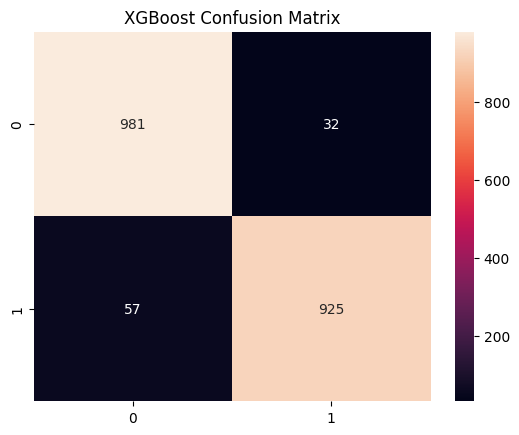

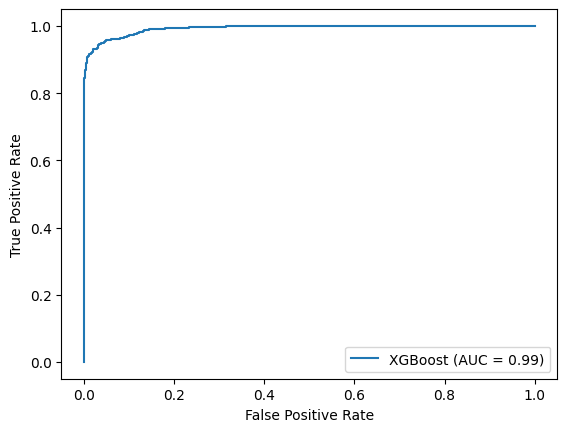

In [106]:
xgb_predictions = best_xgb_model.predict(Xtest)
xgb_conf_matrix = confusion_matrix(y_test, xgb_predictions)
print("XGBoost Classification Report:\n", classification_report(y_test, xgb_predictions))

sns.heatmap(xgb_conf_matrix, annot=True, fmt="g")
plt.title('XGBoost Confusion Matrix')
plt.show()

fpr, tpr, _ = roc_curve(y_test, best_xgb_model.predict_proba(Xtest)[:,1])
roc_auc = auc(fpr, tpr)
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='XGBoost').plot()
plt.show()


## Concluision: Both of our models (RF, xgb) are working with 95% and over 95% accuracy,respectively, with the performance of xgb is a bit better comapred to Rf model based on confusion matrix.

**Testing**

In [107]:
test_set=pd.read_csv("/content/extracted_files/test_dataset.csv")
test_set

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
0,1,Female,Loyal Customer,25,Personal Travel,Eco,2704,2,2,2,...,5,2,4,4,3,5,1,5,152,191.0
1,2,Female,Loyal Customer,49,Business travel,Business,1623,1,1,1,...,4,2,2,2,2,4,2,3,60,52.0
2,3,Male,Loyal Customer,51,Business travel,Business,338,4,4,4,...,5,5,5,5,5,4,5,4,0,0.0
3,4,Male,Loyal Customer,34,Business travel,Eco Plus,95,0,0,0,...,1,5,4,4,1,3,3,5,0,0.0
4,5,Male,Loyal Customer,34,Personal Travel,Eco,602,4,4,4,...,5,5,4,5,4,5,5,5,130,140.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,3996,Male,Loyal Customer,26,Business travel,Business,2949,3,3,4,...,4,4,1,4,2,3,1,4,29,36.0
3996,3997,Female,Loyal Customer,23,Personal Travel,Eco,268,1,3,0,...,2,2,3,2,4,2,3,2,0,0.0
3997,3998,Male,Loyal Customer,38,Business travel,Eco,602,2,1,1,...,2,2,1,1,2,2,3,2,23,45.0
3998,3999,Male,Loyal Customer,23,Business travel,Eco,978,5,2,2,...,4,5,1,5,1,1,3,5,0,0.0


In [108]:
pipelined_test_set = fullpipeline.transform(test_set.drop('id', axis=1))
test_predictions = best_xgb_model.predict(pipelined_test_set)

In [109]:
finalsolution = pd.DataFrame({'id': test_set['id'], 'satisfaction': test_predictions})
finalsolution.to_csv('finalsatisfaction.csv', index=False)